In [1]:
!pip install preprocessor

In [2]:
!pip install wordcloud

In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import preprocessor as p
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from  nltk.tokenize import word_tokenize
from nltk import pos_tag
import matplotlib.pyplot as plt
from textblob import TextBlob
import seaborn as sns
import re

In [4]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 5
page_size = 1000

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    
    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 1000 total reviews
Scraping page 2
   ---> 2000 total reviews
Scraping page 3
   ---> 3000 total reviews
Scraping page 4
   ---> 3913 total reviews
Scraping page 5
   ---> 3913 total reviews


In [5]:
# Create a DataFrame from the reviews list
df = pd.DataFrame(reviews, columns=['reviews'])

# Save the DataFrame to a CSV file
df.to_csv("BA_reviews.csv", index=False)

In [7]:
# Function to clean text
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    return text

# Clean the reviews
df['clean_reviews'] = df['reviews'].apply(clean_text)

# Function to clean verified text from reviews
def clean_verified(review):
    if review[:16] == 'Trip Verified | ':
        review = review[16:]
    elif review[:15] == "Not Verified | ":
        review = review[15:]
    return review

df['clean_reviews'] = df['clean_reviews'].apply(clean_verified)

print("Data cleaning completed and saved to BA_reviews.csv")

Data cleaning completed and saved to BA_reviews.csv


In [9]:
stop_words = set(stopwords.words('english'))
def filter_words(review):
    filtered = []
    for reviews in review:
        word_tokens = word_tokenize(reviews)
        for w in word_tokens:
                if w not in stop_words and w.isalpha():
                    filtered.append(w)
    return (filtered)
reviews=[]
for i in df['clean_reviews']:
    reviews.append(i)
def plot_wordcloud(review,title,max_words):
    words_filtered = filter_words(review)
    text = " ".join([ele for ele in words_filtered])
    word_cloud= WordCloud(background_color="white", random_state=1,stopwords=stop_words,max_words=max_words,width =800, height = 1500)
    word_cloud.generate(text)
    plt.figure(figsize=[10,10])
    plt.imshow(word_cloud,interpolation="bilinear")
    plt.axis('off')
    plt.title(title)
    plt.savefig('foo.png')
    plt.show()

In [10]:
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return [(lemmatizer.lemmatize(w)) for w in word_tokenize(text)]
df['tokenized_reviews'] = df['clean_reviews'].apply(lemmatize_text)
df['tokenized_reviews'] = df['tokenized_reviews'].apply(lambda x: [item for item in x if item not in stop_words])
df['tokenized_reviews'] = df['tokenized_reviews'].apply(lambda x: ' '.join(x))

In [11]:
df

,reviews,clean_reviews,tokenized_reviews
0,"✅ Trip Verified | Terrible overall, medium ser...",trip verified terrible overall medium servic...,trip verified terrible overall medium service ...
1,✅ Trip Verified | London Heathrow to Male In...,trip verified london heathrow to male in n...,trip verified london heathrow male new busines...
2,Not Verified | Very good flight following an ...,not verified very good flight following an e...,verified good flight following equally good fl...
3,Not Verified | An hour's delay due to late ar...,not verified an hours delay due to late arri...,verified hour delay due late arrival incoming ...
4,✅ Trip Verified | I booked through BA becaus...,trip verified i booked through ba because ...,trip verified booked ba loganair dont represen...
...,...,...,...
3908,Flew LHR - VIE return operated by bmi but BA a...,flew lhr vie return operated by bmi but ba ai...,flew lhr vie return operated bmi ba aircraft a...
3909,LHR to HAM. Purser addresses all club passenge...,lhr to ham purser addresses all club passenger...,lhr ham purser address club passenger name boa...
3910,My son who had worked for British Airways urge...,my son who had worked for british airways urge...,son worked british airway urged fly british ai...
3911,London City-New York JFK via Shannon on A318 b...,london citynew york jfk via shannon on a but h...,london citynew york jfk via shannon really nic...


In [15]:

# Perform sentiment analysis on the cleaned reviews and add a sentiment column to the DataFrame
def get_sentiment(review):
    analysis = TextBlob(review)
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'

df['sentiment'] = df['clean_reviews'].apply(get_sentiment)

In [16]:
df

,reviews,clean_reviews,tokenized_reviews,sentiment
0,"✅ Trip Verified | Terrible overall, medium ser...",trip verified terrible overall medium servic...,trip verified terrible overall medium service ...,negative
1,✅ Trip Verified | London Heathrow to Male In...,trip verified london heathrow to male in n...,trip verified london heathrow male new busines...,positive
2,Not Verified | Very good flight following an ...,not verified very good flight following an e...,verified good flight following equally good fl...,positive
3,Not Verified | An hour's delay due to late ar...,not verified an hours delay due to late arri...,verified hour delay due late arrival incoming ...,positive
4,✅ Trip Verified | I booked through BA becaus...,trip verified i booked through ba because ...,trip verified booked ba loganair dont represen...,positive
...,...,...,...,...
3908,Flew LHR - VIE return operated by bmi but BA a...,flew lhr vie return operated by bmi but ba ai...,flew lhr vie return operated bmi ba aircraft a...,positive
3909,LHR to HAM. Purser addresses all club passenge...,lhr to ham purser addresses all club passenger...,lhr ham purser address club passenger name boa...,positive
3910,My son who had worked for British Airways urge...,my son who had worked for british airways urge...,son worked british airway urged fly british ai...,positive
3911,London City-New York JFK via Shannon on A318 b...,london citynew york jfk via shannon on a but h...,london citynew york jfk via shannon really nic...,positive


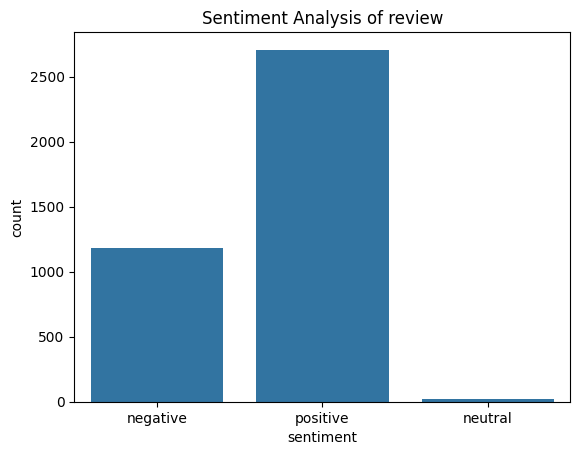

In [17]:
sns.countplot(data=df,x='sentiment')
plt.title('Sentiment Analysis of review')
plt.savefig('foo1.png')